In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *
from scipy.signal import lfilter

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/sev_deltaQ_cycles.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


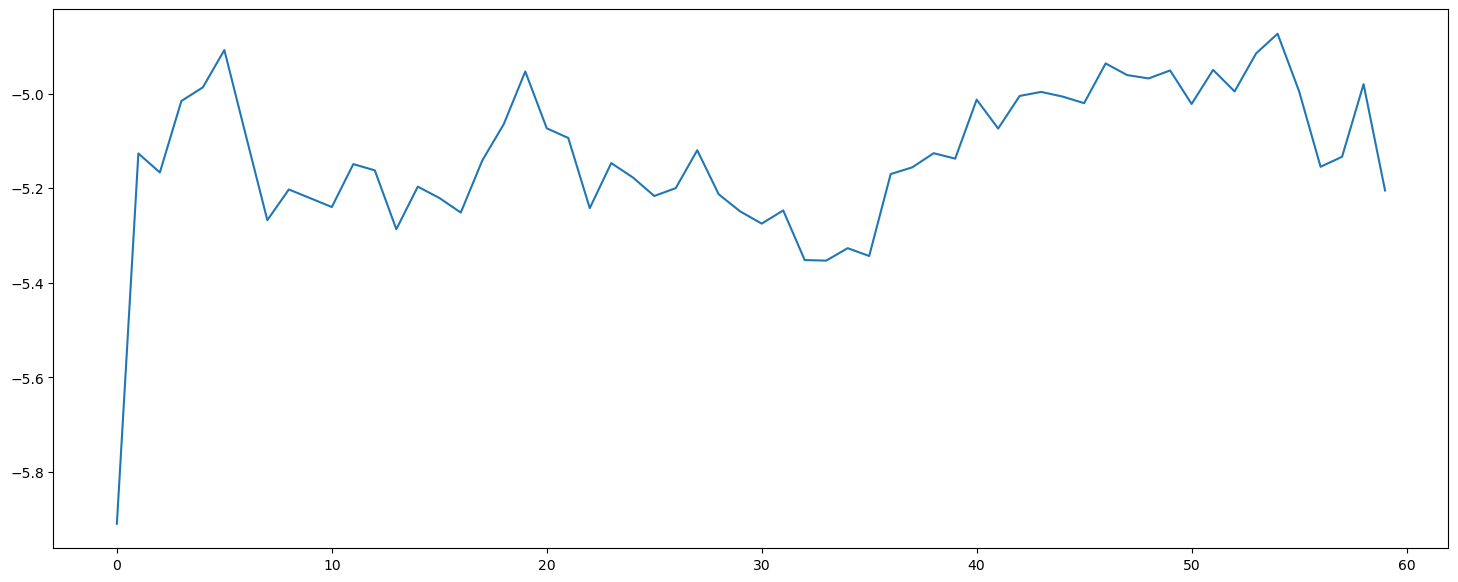

In [55]:
n_cycles = 60
cut_start = 0

features = [
    "DeltaQ_logVars",
    #"DeltaQ_mins",
    #"DeltaQ_means",
    # "DeltaT_max",
    # "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:60]
    #charge_policies[i] = 1/(data[cell]["chargetime_policy"])
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

# scaler = preprocessing.StandardScaler().fit(x)
# x = torch.Tensor(scaler.transform(x))


plt.plot(x[3])

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [56]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])


Stage 1:

Epoch 200/2000,   	decoding loss: 0.04,    	prediction loss: 10365.15,  	reg_loss: 4.44
Epoch 400/2000,   	decoding loss: 0.02,    	prediction loss: 3346.30,  	reg_loss: 4.44
Epoch 600/2000,   	decoding loss: 0.01,    	prediction loss: 2314.94,  	reg_loss: 4.45
Epoch 800/2000,   	decoding loss: 0.23,    	prediction loss: 19973.42,  	reg_loss: 4.45
Epoch 1000/2000,   	decoding loss: 0.09,    	prediction loss: 9.51,  	reg_loss: 4.45
Epoch 1200/2000,   	decoding loss: 0.06,    	prediction loss: 10511.47,  	reg_loss: 4.46
Epoch 1400/2000,   	decoding loss: 0.07,    	prediction loss: 17657.00,  	reg_loss: 4.46
Epoch 1600/2000,   	decoding loss: 0.02,    	prediction loss: 1800.50,  	reg_loss: 4.46
Epoch 1800/2000,   	decoding loss: 0.07,    	prediction loss: 2129.36,  	reg_loss: 4.47
Epoch 2000/2000,   	decoding loss: 0.06,    	prediction loss: 13934.63,  	reg_loss: 4.47

train 	 109.11283
test 	 154.82997
sec 	 436.33182


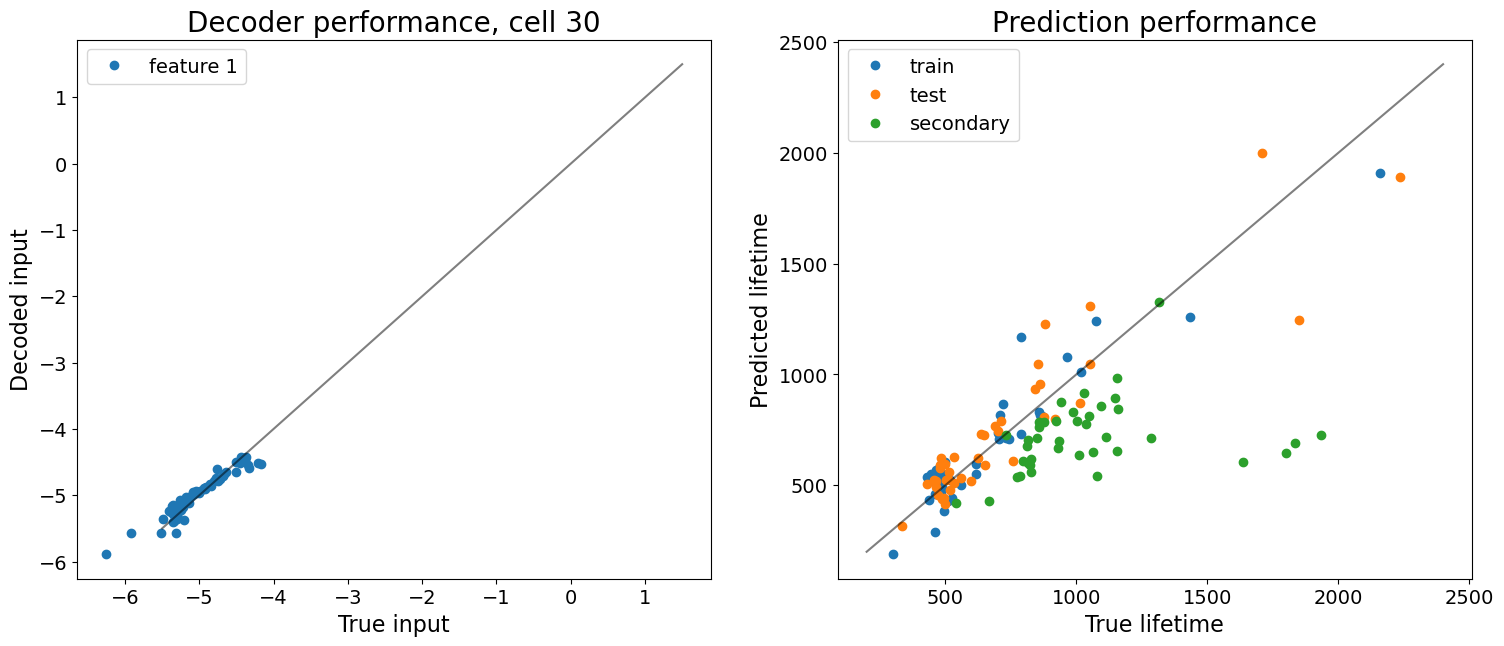

In [61]:
# FOR JUST LOGVAR FEATURE
train_policy = {
    "num_stages": 1,
    "epochs": [2000],
    "learning_rates": [1e-4],
    "batch_sizes": [8],
    "prediction_weights": [1/100],
    "decoding_weights": [1],
    "en_weights": [100]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=2)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [ ]:
# ON DELTAQLOGVARS AND DELTATLOGVARS
train_policy = {
    "num_stages": 1,
    "epochs": [2500],
    "learning_rates": [5e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1/5000],
    "decoding_weights": [50],
    "en_weights": [50]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

Stage 1:

Epoch 20/200,   	decoding loss: 0.32,    	prediction loss: 616027.50,  	reg_loss: 1.68
Epoch 40/200,   	decoding loss: 0.05,    	prediction loss: 849.99,  	reg_loss: 1.34
Epoch 60/200,   	decoding loss: 0.30,    	prediction loss: 25510.26,  	reg_loss: 1.09
Epoch 80/200,   	decoding loss: 0.09,    	prediction loss: 2620.24,  	reg_loss: 0.88
Epoch 100/200,   	decoding loss: 0.06,    	prediction loss: 17726.60,  	reg_loss: 0.71
Epoch 120/200,   	decoding loss: 0.10,    	prediction loss: 940.50,  	reg_loss: 0.58
Epoch 140/200,   	decoding loss: 0.11,    	prediction loss: 16857.54,  	reg_loss: 0.48
Epoch 160/200,   	decoding loss: 0.10,    	prediction loss: 47.76,  	reg_loss: 0.39
Epoch 180/200,   	decoding loss: 0.03,    	prediction loss: 1470.23,  	reg_loss: 0.32
Epoch 200/200,   	decoding loss: 0.04,    	prediction loss: 6193.16,  	reg_loss: 0.26

train 	 89.35874
test 	 126.0318
sec 	 392.64444


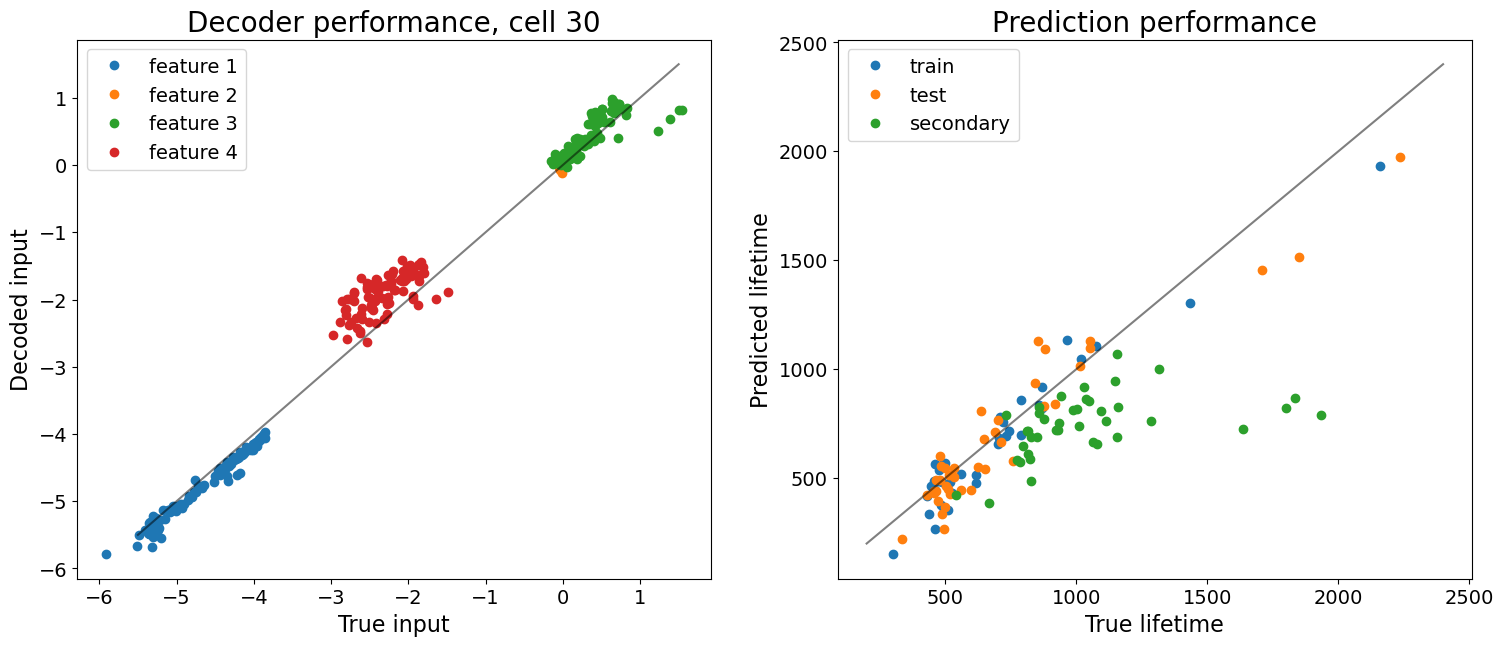

In [53]:
# ON 3 FEATURES
train_policy = {
    "num_stages": 1,
    "epochs": [200],
    "learning_rates": [1e-4],
    "batch_sizes": [8],
    "prediction_weights": [1/80000],
    "decoding_weights": [30],
    "en_weights": [2]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [180]:
model.encoder(x[5])

tensor([ 0.0000, 11.6371,  0.0000,  0.0000,  0.0000,  0.7779,  2.3739,  0.0000,
         0.7495,  2.9191,  0.0000,  0.6527,  0.0000,  0.0000,  0.0000,  0.0000],
       grad_fn=<ReluBackward0>)

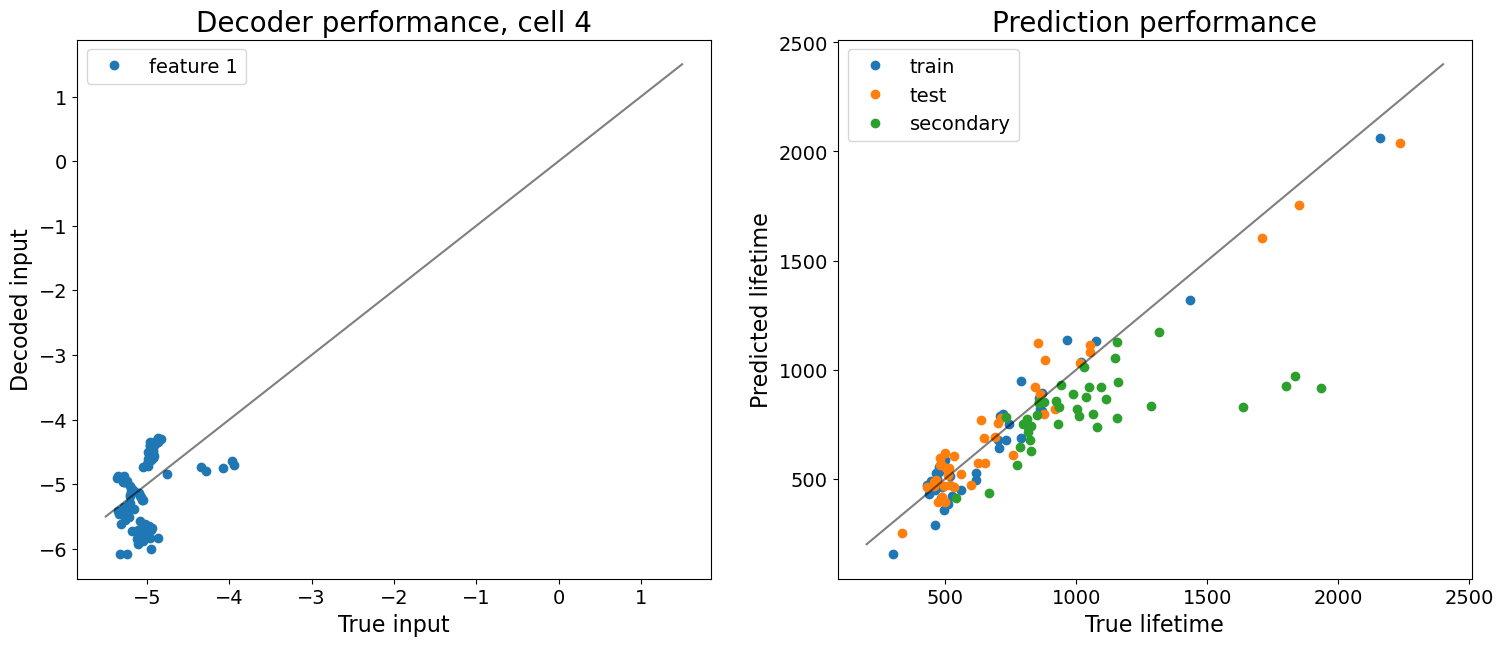

In [71]:
model.plotter(x, y, 4)

In [74]:
print(y[1], model.predict(x[1]))

tensor(3.3345) tensor([3.3144], grad_fn=<AddBackward0>)


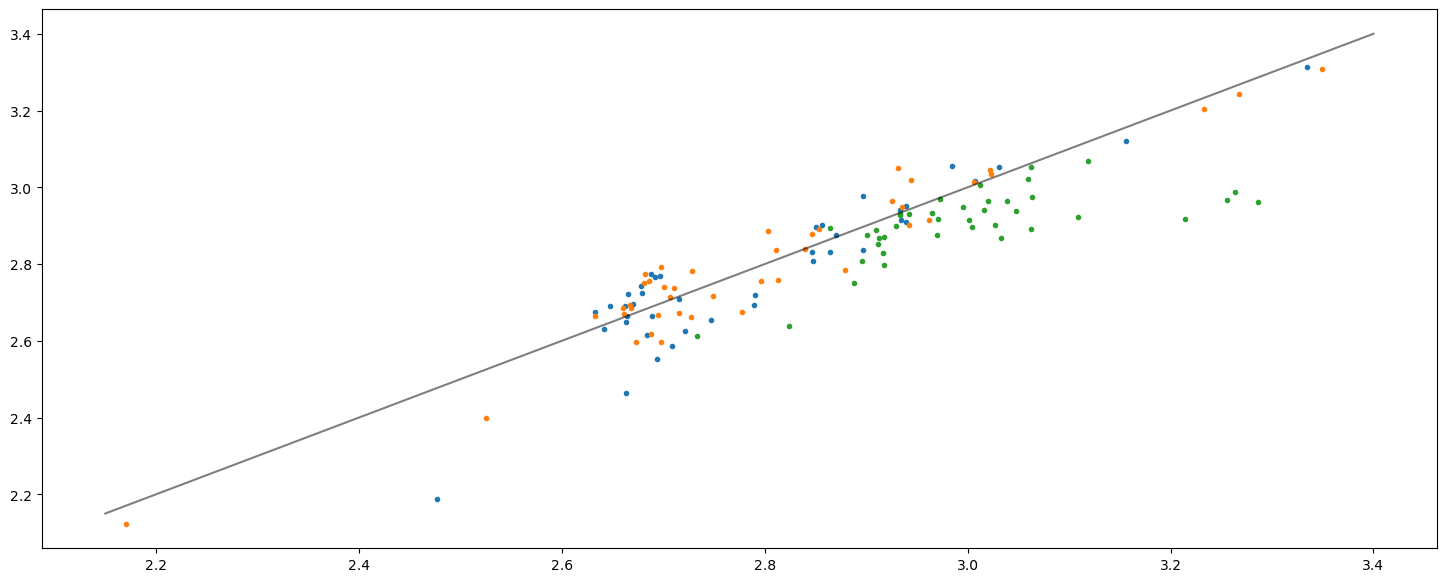

In [76]:
plt.plot(y[train_ind], model.predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [77]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t)

[[0.         7.3516407  0.         7.5625267  0.         4.7638006
  0.         0.         3.294195   0.         4.830704   0.
  0.         0.         0.99521965 0.        ]
 [0.         6.8503003  0.         7.101955   0.         4.5406747
  0.         0.         3.186058   0.         4.5174146  0.
  0.         0.         0.9752435  0.        ]
 [0.         6.6967053  0.         6.931164   0.         4.4770246
  0.         0.         3.1488347  0.         4.393502   0.
  0.         0.         0.98220843 0.        ]
 [0.         6.497127   0.         6.6828084  0.         4.36739
  0.         0.         3.0807598  0.         4.186245   0.
  0.         0.         1.0155442  0.        ]
 [0.         6.5417657  0.         6.7548375  0.         4.3013916
  0.         0.         3.0101     0.         4.3070393  0.
  0.         0.         0.8806112  0.        ]
 [0.         6.372332   0.         6.591417   0.         4.206756
  0.         0.         2.958787   0.         4.179268   0.
  0.  

In [78]:
# scaler = preprocessing.StandardScaler().fit(list(x_t))
# x_t = scaler.transform(list(x_t))
# x_te = scaler.transform(list(x_te))
# x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [79]:
# parameters
lr = 0.001
feat_dim = 1*16
d_model = 2
nepoch = 2000
batch_size = 1

In [80]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [82]:
# Load nodel, loss function, and optimizer
model = AttentionModel2(feat_dim=1,d_model=d_model, n_cycle=feat_dim, skip_connect=1)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  139.067 | rmse_test:  297.466 | rmse_stest:  563.486
Epochs: 100 | rmse:  217.092 | rmse_test:  135.943 | rmse_stest:  278.918
Epochs: 150 | rmse:  186.136 | rmse_test:  179.770 | rmse_stest:  443.291
Epochs: 200 | rmse:  309.243 | rmse_test:  98.162 | rmse_stest:  306.872
Epochs: 250 | rmse:  113.190 | rmse_test:  169.938 | rmse_stest:  428.524
Epochs: 300 | rmse:  143.854 | rmse_test:  99.449 | rmse_stest:  303.352
Epochs: 350 | rmse:  115.912 | rmse_test:  100.885 | rmse_stest:  301.903
Epochs: 400 | rmse:  218.102 | rmse_test:  153.778 | rmse_stest:  267.709
Epochs: 450 | rmse:  121.576 | rmse_test:  113.338 | rmse_stest:  283.737
Epochs: 500 | rmse:  93.792 | rmse_test:  129.483 | rmse_stest:  383.207
Epochs: 550 | rmse:  102.486 | rmse_test:  105.293 | rmse_stest:  292.766
Epochs: 600 | rmse:  98.126 | rmse_test:  99.524 | rmse_stest:  331.308
Epochs: 650 | rmse:  91.358 | rmse_test:  97.911 | rmse_stest:  330.602
Epochs: 700 | rmse:  97.494 | rmse_test:  105.

In [ ]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

In [ ]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)[:,0]-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)